# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Project Setup

In [28]:
# all import statements needed for the project, for example:

import os
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import re
import geopandas as gpd
import math
import glob
import numpy as np
from scipy import stats
import sqlite3
import sqlalchemy as db
from sqlalchemy import create_engine, text, inspect 
import folium
from folium.plugins import HeatMap
import seaborn as sns

In [29]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

PARQUET_FILES = "parquet_files"
TAXI_ZONES_DIR = "taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = "weather_data"

#CRS = 4326  # coordinate reference system

# (lat, lon)
#NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [30]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Download All data

In [25]:
def get_all_urls_from_tlc_page():
    """
    Fetch the HTML content of the TLC page.
    
    Returns:
        raw HTML content of the TLC page as a bytes object."""
    response = requests.get(TLC_URL)
    html = response.content
    return html

In [26]:
#Identifies all of the yellow and fhvhv parquet files for years 2020 - 2024
pattern = re.compile(r".*(yellow|fhvhv).*(2020|2021|2022|2023|2024)-\d{2}\.parquet")

def filter_parquet_urls():
    """
    Filter and extract parquet file URLs from the TLC page.

    Returns:
        list: A list of URLs pointing to parquet files matching the filter criteria.
    """
    html = get_all_urls_from_tlc_page()
    soup = bs4.BeautifulSoup(html, "html.parser")
    urls = soup.find_all("a", href=pattern)
    parquet_urls = [link["href"].strip() for link in urls]
    return parquet_urls

In [27]:
folder_name = "parquet_files"
# Check if the folder exists
if not os.path.exists(folder_name):
    os.mkdir(folder_name)
    print(f"Folder '{folder_name}' created successfully!")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'parquet_files' already exists.


In [28]:
# parses the filename from the link and then downloads the files one by one
def download_parquet_files():
    """
    Download parquet files from the filtered URLs and save them locally.

    Returns:
        None: saves the parquet files to local machine.
    """
    for link in filter_parquet_urls():
        filename = link.split("/")[-1]
        r = requests.get(link)
        with open(f"parquet_files/{filename}", "wb") as f:
            f.write(r.content)

#run the first time to download data
#download_parquet_files()

### Load Taxi Zones & Parquet Files

In [31]:
#Reads the shape file
def load_taxi_zones(shapefile):
    """
    Load a GeoDataFrame from a given shapefile.

    Args:
        shapefile (str): The path to the shapefile.

    Returns:
        geopandas.GeoDataFrame: The loaded taxi zones as a GeoDataFrame.
    """
    taxi_zones = gpd.read_file(shapefile)
    return taxi_zones

In [32]:
# load our geodataframe and take a look at it  
gdf_taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
print(gdf_taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((9.33e+05 1.93e+05, 9.33e+05 1.93e+05...  
1         Queens  MULTIPOLYGON (((1.03e+06 1.72e+05, 1.03e+06 1....  
2          Bronx  POLYGON ((1.03e+06 2.57e+05, 1.03e+06 2.57e+05...  
3      Manhattan  POLYGON ((9.92e+05 2.04e+05, 9.92e+05 2.04e+05...  
4  Staten Island  POLYGON ((9.36e+05 1.44e+05, 9.36e+05 1.44e+05...  


In [33]:
# converts taxi zone geometry coordinates to the appropriate coordinate system  
gdf_taxi_zones = gdf_taxi_zones.to_crs(epsg=4326)
gdf_taxi_zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.184 40.695, -74.184 40.695, -74...."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.823 40.639, -73.823 40.636..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.848 40.871, -73.847 40.871, -73...."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.972 40.726, -73.972 40.726, -73...."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.174 40.563, -74.173 40.562, -74...."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.851 40.91, -73.852 40.909, -73.8..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.902 40.761, -73.901 40.76, -73.9..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.013 40.705, -74.013 40.705, -74...."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.944 40.783, -73.944 40.783..."


In [34]:
# load parquet file into a pandas DataFrame
def load_parquet_file(file_path):
    """
    Load a pandas DataFrame from a given parquet file.

    Args:
        file_path (str): The path to the parquet file.

    Returns:
        pandas.DataFrame: The loaded data as a DataFrame.
    """
    df = pd.read_parquet(file_path)
    return df

In [35]:
# load a random yellow taxi trip parquet file to check if the function works correctly for testing purposes
example = os.path.join(PARQUET_FILES, "yellow_tripdata_2023-01.parquet")
example_df = load_parquet_file(example)

# preview the data
print(example_df.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:32:10   2023-01-01 00:40:36              1.0   
1         2  2023-01-01 00:55:08   2023-01-01 01:01:27              1.0   
2         2  2023-01-01 00:25:04   2023-01-01 00:37:49              1.0   
3         1  2023-01-01 00:03:48   2023-01-01 00:13:25              0.0   
4         2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.97         1.0                  N           161           141   
1           1.10         1.0                  N            43           237   
2           2.51         1.0                  N            48           238   
3           1.90         1.0                  N           138             7   
4           1.43         1.0                  N           107            79   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [36]:
# load a random High-Volume For-Hire Vehicle trip parquet file to check if the function works correctly
example2 = os.path.join(PARQUET_FILES, "fhvhv_tripdata_2023-01.parquet")
example_df2 = load_parquet_file(example2)

# preview the data
print(example_df2.head())

  hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B03404               B03404   
1            HV0003               B03404               B03404   
2            HV0003               B03404               B03404   
3            HV0003               B03404               B03404   
4            HV0003               B03404               B03404   

     request_datetime   on_scene_datetime     pickup_datetime  \
0 2023-01-01 00:18:06 2023-01-01 00:19:24 2023-01-01 00:19:38   
1 2023-01-01 00:48:42 2023-01-01 00:56:20 2023-01-01 00:58:39   
2 2023-01-01 00:15:35 2023-01-01 00:20:14 2023-01-01 00:20:27   
3 2023-01-01 00:35:24 2023-01-01 00:39:30 2023-01-01 00:41:05   
4 2023-01-01 00:43:15 2023-01-01 00:51:10 2023-01-01 00:52:47   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  sales_tax  \
0 2023-01-01 00:48:07            48            68        0.94  ...       2.30   
1 2023-01-01 01:33:08           246           163       

In [37]:
# Identify columns in High-Volume For-Hire Vehicle trip parquet file for context 
example_df2.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [38]:
# Identify columns in Uber trip parquet file for context 
example_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

### Cleaning and Filtering
* Remove all non-Uber data from fhvhv
* Remove all invalid pickup and dropoff location IDs for both uber and yellow taxi, where ID is greater than 263 using the `shp` file
* Remove unnecessary columns and only keeping columns needed to answer questions in the other parts of this project
* Remove invalid data points (use your discretion!)
* normalize column names; 
normalieg and using appropriate column types for the respective dat

* Remove trips from both uber and yellow taxi that start and/or end outside of the following latitude/longitude coordinate box: (40.560445, -74.242330) and (40.908524, -73.71704).


In [39]:
# Compute the center of the taxi zones for easier comparison and adds a column to the df of our shapefile 
gdf_taxi_zones['centroid'] = gdf_taxi_zones.geometry.centroid

# Rename 'LocationID' to 'location_id' for consistency
gdf_taxi_zones = gdf_taxi_zones.rename(columns={'LocationID': 'location_id'})

# Removes the bulky geometry column after using it to compute centroid. 
gdf_taxi_zones = gdf_taxi_zones[['zone', 'location_id', 'centroid']]

/var/folders/wc/z6g_m0_n659dtcmkkgf76pv40000gn/T/ipykernel_4637/1283153998.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_taxi_zones['centroid'] = gdf_taxi_zones.geometry.centroid


In [40]:
gdf_taxi_zones

,zone,location_id,centroid
0,Newark Airport,1,POINT (-74.174 40.692)
1,Jamaica Bay,2,POINT (-73.831 40.617)
2,Allerton/Pelham Gardens,3,POINT (-73.847 40.864)
3,Alphabet City,4,POINT (-73.977 40.724)
4,Arden Heights,5,POINT (-74.188 40.553)
...,...,...,...
258,Woodlawn/Wakefield,259,POINT (-73.852 40.898)
259,Woodside,260,POINT (-73.906 40.744)
260,World Trade Center,261,POINT (-74.013 40.709)
261,Yorkville East,262,POINT (-73.947 40.776)


### Calculate Sample Size

In [41]:
# default: 95% confidence interval, 5% margin of error, p of 0.5 (estimated) proportion of the population which has the attribute in question
def cochran_sample_size(population_size):
    """
    Calculate the required sample size using Cochran's formula.

    Args:
        population_size (int): The total size of the population.

    Returns:
        int: The adjusted sample size based on the population size.
    """
    z_score=1.96
    margin_of_error=0.05
    p=0.5
    sample_size = ((z_score**2)*p*(1-p)) / (margin_of_error**2)
    adjusted_sample_size = sample_size / (1 + ((sample_size-1)/population_size))

    return int(adjusted_sample_size)

### Common Functions

In [42]:
# Filter function to remove unnecessary rows
def filter_data(data):
    """
    Filter a dataset to remove unnecessary rows based on specific conditions.

    Args:
        data (pandas.DataFrame): The dataset containing taxi ride information.

    Returns:
        pandas.DataFrame: The filtered dataset.
    """
    # Ensure PU and DO locations are within valid location IDs (<= 263)
    data = data[(data['pickup_location_id'] <= 263) & (data['dropoff_location_id'] <= 263)]
    # Filters out rides where pickup and dropoff locations are the same
    filtered_data = data[data['trip_distance'] != 0]
        
    return filtered_data

In [43]:
# Removes trips from both uber and yellow taxi that start and/or end outside of the following latitude/longitude coordinate box:
def find_centroid(data):
    """
    Remove trips that start and/or end outside a specified latitude/longitude bounding box.

    Args:
        data (pandas.DataFrame): The dataset containing trip data with a 'centroid' column.

    Returns:
        pandas.DataFrame: The filtered dataset containing trips within the bounding box.
    """
    LAT_MIN, LON_MIN = 40.560445, -74.242330
    LAT_MAX, LON_MAX = 40.908524, -73.717047
    
    # Extract latitude and longitude from the 'centroid' column using .apply()
    data['centroid_lat'] = data['centroid'].apply(lambda point: point.y)
    data['centroid_lon'] = data['centroid'].apply(lambda point: point.x)
    
    # Filter rows where the centroid coordinates are within the bounding coordinate box
    centroid_data = data[
        (data['centroid_lat'] >= LAT_MIN) & (data['centroid_lat'] <= LAT_MAX) &
        (data['centroid_lon'] >= LON_MIN) & (data['centroid_lon'] <= LON_MAX)
    ]
    return centroid_data

### Process Taxi Data

In [44]:
#Grab all of the parquet files in the directory. glob.glob is used to identify/match the pattern, path.join retrieves all the paths 
all_taxi_parquet_files = glob.glob(os.path.join(PARQUET_FILES, "*yellow*.parquet"))

In [45]:
# Create a mapping to normalize names for taxi data 
taxi_columns_mapping = {
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'extra': 'rush_hour_surcharge',
    'PULocationID': 'pickup_location_id',
    'DOLocationID': 'dropoff_location_id',
     'fare_amount': 'base_passenger_fare',
    'RatecodeID': 'rate_code_id'
}

# Make a list of just the columns we need for analysis
columns_to_keep = [
    'pickup_datetime', 'dropoff_datetime', 'trip_distance', 'rate_code_id',
    'pickup_location_id', 'dropoff_location_id', 'base_passenger_fare', 'rush_hour_surcharge', 'mta_tax',
    'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
    'congestion_surcharge', 'airport_fee'
]

# Create samples of all taxi parquet files according to cochran's sample size formula. Later, we concatenate all sample dfs into one df. 
sampled_taxi_dfs = []

for file_path in all_taxi_parquet_files:      
    taxi_df = load_parquet_file(file_path) # Makes a df for every parquet file 
    taxi_df = taxi_df.rename(columns=taxi_columns_mapping) # Normalize column names based on mapping above 

    population_size = len(taxi_df)
    sample_size = cochran_sample_size(population_size)
    sampled_taxi_df = taxi_df.sample(n=sample_size, random_state=42)
    
    # We found that there were a few files that did not have airport_fee as a column. We populate airport_fee with NaN for such parquet files.
    for col in columns_to_keep:  
        if col not in sampled_taxi_df.columns:
            sampled_taxi_df[col] = np.nan 
    sampled_taxi_df = sampled_taxi_df[columns_to_keep]
    sampled_taxi_dfs.append(sampled_taxi_df)

# create one gigantic dataframe with data from every month needed
sampled_taxi_data = pd.concat(sampled_taxi_dfs)
# Remove unecessary rows using our filter function defined above 
sampled_taxi_data = filter_data(sampled_taxi_data)

# Make a single df that includes the taxi rides and their corresponding coordinates by merging the shape file with the ride files.
final_taxi_data = pd.merge(sampled_taxi_data, gdf_taxi_zones, left_on = 'pickup_location_id', right_on = 'location_id', how="inner")

# Remove rows that are outside of our region of interest 
final_taxi_data = find_centroid(final_taxi_data)

# Drop the centroid column, and just keep the latitude and longitude columns as that is more compatible for SQL 
final_taxi_data = final_taxi_data.drop(columns=['centroid'])

/var/folders/wc/z6g_m0_n659dtcmkkgf76pv40000gn/T/ipykernel_4637/3822900639.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sampled_taxi_data = pd.concat(sampled_taxi_dfs)


In [46]:
final_taxi_data.head()

,pickup_datetime,dropoff_datetime,trip_distance,rate_code_id,pickup_location_id,dropoff_location_id,base_passenger_fare,rush_hour_surcharge,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,zone,location_id,centroid_lat,centroid_lon
0,2023-06-28 08:27:09,2023-06-28 09:21:52,10.22,1.0,138,144,57.6,5.0,0.5,17.09,0.00,1.0,85.44,2.5,NaN,LaGuardia Airport,138,40.774375,-73.873629
1,2023-06-13 22:05:38,2023-06-13 22:10:48,0.80,1.0,263,237,7.2,3.5,0.5,0.00,0.00,1.0,12.20,2.5,NaN,Yorkville West,263,40.778765,-73.951010
2,2023-06-09 10:25:49,2023-06-09 10:41:51,1.62,1.0,162,236,15.6,0.0,0.5,2.00,0.00,1.0,21.60,2.5,NaN,Midtown East,162,40.756687,-73.972356
3,2023-06-28 15:56:14,2023-06-28 17:22:03,18.90,3.0,229,1,114.7,0.0,0.0,27.65,22.75,1.0,166.10,0.0,NaN,Sutton Place/Turtle Bay North,229,40.756728,-73.965146
4,2023-06-22 07:12:42,2023-06-22 07:23:47,1.52,1.0,43,74,11.4,0.0,0.5,1.94,0.00,1.0,14.84,0.0,NaN,Central Park,43,40.782478,-73.965553


In [47]:
final_taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20826 entries, 0 to 20828
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   pickup_datetime        20826 non-null  datetime64[us]
 1   dropoff_datetime       20826 non-null  datetime64[us]
 2   trip_distance          20826 non-null  float64       
 3   rate_code_id           19770 non-null  float64       
 4   pickup_location_id     20826 non-null  int64         
 5   dropoff_location_id    20826 non-null  int64         
 6   base_passenger_fare    20826 non-null  float64       
 7   rush_hour_surcharge    20826 non-null  float64       
 8   mta_tax                20826 non-null  float64       
 9   tip_amount             20826 non-null  float64       
 10  tolls_amount           20826 non-null  float64       
 11  improvement_surcharge  20826 non-null  float64       
 12  total_amount           20826 non-null  float64       
 13  conges

In [48]:
final_taxi_data.describe()

,pickup_datetime,dropoff_datetime,trip_distance,rate_code_id,pickup_location_id,dropoff_location_id,base_passenger_fare,rush_hour_surcharge,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,location_id,centroid_lat,centroid_lon
count,20826,20826,20826.000000,19770.000000,20826.000000,20826.000000,20826.000000,20826.000000,20826.000000,20826.000000,20826.000000,20826.000000,20826.000000,19770.000000,7947.000000,20826.000000,20826.000000,20826.000000
mean,2022-05-01 10:17:07.596273,2022-05-01 10:33:09.629309,3.275384,1.415023,164.151157,160.661001,15.153432,1.205869,0.490733,2.680401,0.431877,0.543945,22.188515,2.297547,0.086825,164.151157,40.753285,-73.966859
min,2020-01-01 00:11:06,2020-01-01 00:30:50,0.010000,1.000000,4.000000,1.000000,-81.520000,-7.500000,-0.500000,0.000000,-34.200000,-1.000000,-108.200000,-2.500000,-1.250000,4.000000,40.576961,-74.029892
25%,2021-02-28 21:30:14.250000,2021-02-28 21:36:58.750000,1.090000,1.000000,132.000000,107.000000,7.200000,0.000000,0.500000,0.000000,0.000000,0.300000,12.600000,2.500000,0.000000,132.000000,40.740337,-73.989844
50%,2022-04-30 15:36:52.500000,2022-04-30 16:06:25,1.800000,1.000000,162.000000,161.000000,10.700000,0.500000,0.500000,2.160000,0.000000,0.300000,16.800000,2.500000,0.000000,162.000000,40.758027,-73.977698
75%,2023-06-29 14:40:03,2023-06-29 14:50:15.250000,3.310000,1.000000,234.000000,234.000000,17.000000,2.500000,0.500000,3.440000,0.000000,1.000000,24.360000,2.500000,0.000000,234.000000,40.773633,-73.961763
max,2024-08-31 22:43:47,2024-08-31 23:26:23,67.900000,99.000000,263.000000,263.000000,209.500000,11.750000,0.500000,50.000000,40.000000,1.000000,262.700000,2.500000,1.250000,263.000000,40.899529,-73.739337
std,NaN,NaN,4.121171,6.028092,65.215425,70.490221,13.948344,1.512793,0.089069,3.157641,1.825400,0.351174,17.759500,0.735558,0.321505,65.215425,0.032466,0.045223


### Processing Uber Data

In [49]:
# Grab all of the parquet files in the directory. glob.glob is used to identify/match the pattern, path.join retrieves all the paths 
all_fhvhv_parquet_files = glob.glob(os.path.join(PARQUET_FILES, "*fhvhv*.parquet"))

In [50]:
# Make a mapping to normalize column names in uber data 
uber_columns_mapping = {
    'trip_miles': 'trip_distance',
    'PULocationID': 'pickup_location_id',
    'DOLocationID': 'dropoff_location_id',
    'tolls': 'tolls_amount',
    'tips': 'tip_amount',
    'bcf': 'black_car_fund_fee',
    
}

# Create samples of all uber parquet files according to cochran's sample size formula. Later, we concatenate all sample dfs into one df. 
sampled_uber_dfs = []
columns_to_keep = ['hvfhs_license_num',
       'request_datetime', 'pickup_datetime',
       'dropoff_datetime', 'pickup_location_id', 'dropoff_location_id', 'trip_distance',
        'base_passenger_fare', 'tolls_amount', 'black_car_fund_fee', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tip_amount']

for file_path in all_fhvhv_parquet_files:      
    uber_df = load_parquet_file(file_path) #Makes a df for every parquet file 
    uber_df = uber_df.rename(columns=uber_columns_mapping)
    uber_df = uber_df[uber_df['hvfhs_license_num'] == 'HV0003'] #Filters out non-uber rides from the hvfhs files before creating samples
    population_size = len(uber_df)
    sample_size = cochran_sample_size(population_size)
    sampled_uber_df = uber_df.sample(n=sample_size, random_state=42)
    sampled_uber_df = sampled_uber_df[columns_to_keep]
    sampled_uber_dfs.append(sampled_uber_df)

# create one gigantic dataframe with data from every month needed
sampled_uber_data = pd.concat(sampled_uber_dfs)

# Remove uneccessary rows using our filter function defined above 
sampled_uber_data = filter_data(sampled_uber_data)

# Make a single df that includes the taxi rides and their corresponding coordinates by merging the shape file with the ride files.
final_uber_data = pd.merge(sampled_uber_data, gdf_taxi_zones, left_on = 'pickup_location_id', right_on = 'location_id', how="inner")

# Removes rows that are outside of our region of interest 
final_uber_data = find_centroid(final_uber_data)

#Remove the centroid column and just keep the latitude and longitude for SQL compatibility
final_uber_data = final_uber_data.drop(columns=['centroid'])

/var/folders/wc/z6g_m0_n659dtcmkkgf76pv40000gn/T/ipykernel_4637/4249154977.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sampled_uber_data = pd.concat(sampled_uber_dfs)


In [51]:
final_uber_data.head()

,hvfhs_license_num,request_datetime,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,trip_distance,base_passenger_fare,tolls_amount,black_car_fund_fee,sales_tax,congestion_surcharge,airport_fee,tip_amount,zone,location_id,centroid_lat,centroid_lon
0,HV0003,2021-03-19 08:07:07,2021-03-19 08:11:50,2021-03-19 08:20:59,97,231,2.52,12.58,0.00,0.39,1.14,2.75,NaN,0.0,Fort Greene,97,40.690786,-73.974882
1,HV0003,2021-03-01 22:02:07,2021-03-01 22:08:28,2021-03-01 22:20:19,247,20,2.41,11.94,0.00,0.36,1.06,0.00,NaN,0.0,West Concourse,247,40.828988,-73.924409
2,HV0003,2021-03-13 05:42:59,2021-03-13 05:48:40,2021-03-13 05:55:36,18,247,2.21,15.25,0.00,0.46,1.35,0.00,NaN,0.0,Bedford Park,18,40.867682,-73.890183
3,HV0003,2021-03-12 20:58:30,2021-03-12 21:02:02,2021-03-12 21:25:13,211,229,3.85,21.51,0.00,0.65,1.91,2.75,NaN,0.0,SoHo,211,40.723888,-74.001537
4,HV0003,2021-03-31 08:42:41,2021-03-31 08:49:53,2021-03-31 09:56:02,74,45,18.96,71.31,6.12,2.33,6.89,2.75,0.0,0.0,East Harlem North,74,40.801169,-73.937345


In [52]:
final_uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20678 entries, 0 to 20731
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   hvfhs_license_num     20678 non-null  object        
 1   request_datetime      20678 non-null  datetime64[us]
 2   pickup_datetime       20678 non-null  datetime64[us]
 3   dropoff_datetime      20678 non-null  datetime64[us]
 4   pickup_location_id    20678 non-null  int64         
 5   dropoff_location_id   20678 non-null  int64         
 6   trip_distance         20678 non-null  float64       
 7   base_passenger_fare   20678 non-null  float64       
 8   tolls_amount          20678 non-null  float64       
 9   black_car_fund_fee    20678 non-null  float64       
 10  sales_tax             20678 non-null  float64       
 11  congestion_surcharge  20678 non-null  float64       
 12  airport_fee           15107 non-null  float64       
 13  tip_amount           

In [53]:
final_uber_data.describe()

,request_datetime,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,trip_distance,base_passenger_fare,tolls_amount,black_car_fund_fee,sales_tax,congestion_surcharge,airport_fee,tip_amount,location_id,centroid_lat,centroid_lon
count,20678,20678,20678,20678.000000,20678.000000,20678.000000,20678.000000,20678.000000,20678.000000,20678.000000,20678.000000,15107.000000,20678.000000,20678.000000,20678.000000,20678.000000
mean,2022-04-29 03:51:06.178257,2022-04-29 03:55:45.584002,2022-04-29 04:13:38.630138,137.800077,137.759745,4.439277,21.201442,0.656449,0.620884,1.895659,1.052326,0.191468,0.820059,137.800077,40.737433,-73.934434
min,2020-01-01 01:14:43,2020-01-01 01:21:23,2020-01-01 01:46:38,3.000000,1.000000,0.020000,-9.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,40.561994,-74.170887
25%,2021-02-24 10:25:41.250000,2021-02-24 10:29:33.250000,2021-02-24 10:49:42.250000,73.000000,74.000000,1.540000,10.490000,0.000000,0.290000,0.910000,0.000000,0.000000,0.000000,73.000000,40.690786,-73.984196
50%,2022-04-25 21:30:18,2022-04-25 21:33:31.500000,2022-04-25 21:42:09,139.000000,138.000000,2.810000,16.720000,0.000000,0.470000,1.470000,0.000000,0.000000,0.000000,139.000000,40.737698,-73.948789
75%,2023-06-30 11:11:37,2023-06-30 11:14:15,2023-06-30 11:23:13.250000,211.000000,209.000000,5.710000,26.570000,0.000000,0.770000,2.380000,2.750000,0.000000,0.000000,211.000000,40.774375,-73.898956
max,2024-08-31 23:43:36,2024-08-31 23:49:13,2024-09-01 00:10:26,263.000000,263.000000,42.660000,255.840000,43.910000,7.950000,23.510000,2.750000,5.000000,40.000000,263.000000,40.899529,-73.726656
std,NaN,NaN,NaN,75.489021,75.367212,4.359484,15.753046,2.520313,0.500625,1.450202,1.332477,0.670128,2.429705,75.489021,0.069218,0.065377


### Processing Weather Data

In [56]:
def get_all_weather_csvs(directory):
    """
    Load and concatenate all CSV files from a specified directory into a single DataFrame.

    Args:
        directory (str): The path to the directory containing the CSV files.

    Returns:
        pandas.DataFrame: A DataFrame containing the concatenated data from all CSV files.
    """
    weather_dfs = []

    # Iterate over all files in the given directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path, low_memory=False, encoding='ISO-8859-1')
        # Append the DataFrame to the list
        weather_dfs.append(df)
    weather_dfs = pd.concat(weather_dfs, ignore_index=True)
    return weather_dfs



In [57]:
columns_to_keep = ['DATE','LATITUDE', 'LONGITUDE', 'MonthlyTotalLiquidPrecipitation', 'DailyPrecipitation', 'HourlyPrecipitation', 'DailyAverageWindSpeed', 'HourlyWindSpeed', 'DailySnowfall']

weather_data = get_all_weather_csvs(WEATHER_CSV_DIR)
weather_data = weather_data[columns_to_keep]
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

# Check how many rows don't have hourly precipiation populated -> these will need to be backfilled. 
weather_data[weather_data["HourlyPrecipitation"].isna()] #8,523


# Normalize columns in weather csvs 
weather_columns_mapping = {
 'DATE': 'date',
 'LATITUDE': 'latitude',
 'LONGITUDE': 'longitude',
 'DailyPrecipitation': 'daily_precipitation',
 'HourlyPrecipitation': 'hourly_precipitation',
 'DailyAverageWindSpeed': 'daily_average_wind_speed',
 'HourlyWindSpeed': 'hourly_wind_speed',
 'DailySnowfall': 'daily_snowfall'
}
weather_data.rename(columns=weather_columns_mapping, inplace=True)


In [58]:
# We needed to do this because an error was being thrown that the hourly precipitation values were strings. 
# Identify rows where HourlyPrecipitation is a string
string_precipitation_rows = weather_data[weather_data['hourly_precipitation'].apply(lambda x: isinstance(x, str))]

# Extract the HourlyPrecipitation values that are strings
string_values = string_precipitation_rows['hourly_precipitation']

# Get unique values and their count using value_counts()
string_value_counts = string_values.value_counts()

# Print or display the unique string values and their count
print("Unique String Values and Their Counts in HourlyPrecipitation:")
print(string_value_counts.head())


Unique String Values and Their Counts in HourlyPrecipitation:
hourly_precipitation
0.00    36284
T        3706
0.01     1966
0.02     1081
0.03      752
Name: count, dtype: int64


In [59]:
# Cleans out the string values based on different cases identified in the query above
# Replace 'T' (trace amount) with 0.00
weather_data['hourly_precipitation'].replace('T', 0.00, inplace=True)

# Function to clean non-numeric characters from values
def clean_precipitation_value(value):
    """
    Clean precipitation value by removing all non-numeric characters except the decimal point.

    Args:
        value (str or any): The precipitation value to clean.

    Returns:
        str or any: The cleaned value as a string if the input was a string; otherwise, 
        returns the original value.
    """
    if isinstance(value, str):
        # Remove all non-numeric characters except the decimal point
        return re.sub(r'[^0-9.]', '', value)
    return value

# Apply the cleaning function to the HourlyPrecipitation column
weather_data['hourly_precipitation'] = weather_data['hourly_precipitation'].apply(clean_precipitation_value)

# Convert all cleaned values to numeric, coercing any problematic ones to NaN
weather_data['hourly_precipitation'] = pd.to_numeric(weather_data['hourly_precipitation'], errors='coerce')

# Display the cleaned DataFrame
print(weather_data.head())

                 date  latitude  longitude MonthlyTotalLiquidPrecipitation  \
0 2020-01-01 00:51:00  40.77898  -73.96925                             NaN   
1 2020-01-01 01:51:00  40.77898  -73.96925                             NaN   
2 2020-01-01 02:51:00  40.77898  -73.96925                             NaN   
3 2020-01-01 03:51:00  40.77898  -73.96925                             NaN   
4 2020-01-01 04:51:00  40.77898  -73.96925                             NaN   

  daily_precipitation  hourly_precipitation  daily_average_wind_speed  \
0                 NaN                   0.0                       NaN   
1                 NaN                   0.0                       NaN   
2                 NaN                   0.0                       NaN   
3                 NaN                   0.0                       NaN   
4                 NaN                   0.0                       NaN   

   hourly_wind_speed daily_snowfall  
0                8.0            NaN  
1               

/var/folders/wc/z6g_m0_n659dtcmkkgf76pv40000gn/T/ipykernel_4637/1846558131.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_data['hourly_precipitation'].replace('T', 0.00, inplace=True)


In [60]:
# Fill in the remaining null hourly precipiation values 
# Ensure that 'DATE' is in the correct datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Add a column for just the date (without time), which will help with grouping
weather_data['DATE_ONLY'] = weather_data['date'].dt.date
# Group by each unique date
daily_groups = weather_data.groupby('DATE_ONLY')

# Loop over each group of a specific date and calculate the remaining precipitation to distribute
for date, group in daily_groups:
    # Get the daily precipitation for the current day
    daily_precipitation = group['daily_precipitation'].iloc[0]
    
    # Calculate the sum of existing hourly precipitation values (if any)
    existing_hourly_precip = group['hourly_precipitation'].sum(skipna=True)

    # Calculate the remaining precipitation that needs to be distributed to missing hours
    remaining_precip = daily_precipitation - existing_hourly_precip

    # Get the number of hours with missing HourlyPrecipitation
    missing_hours = group['hourly_precipitation'].isna().sum()

    # Calculate how much to distribute to each missing hour
    if missing_hours > 0 and remaining_precip > 0:
        hourly_precipitation_to_assign = remaining_precip / missing_hours
    else:
        hourly_precipitation_to_assign = 0

    # Fill missing HourlyPrecipitation values with the calculated amount
    weather_data.loc[group.index, 'hourly_precipitation'] = group['hourly_precipitation'].fillna(hourly_precipitation_to_assign)


In [61]:
#Confirm there are no null hourly precipitation values anymore 
weather_data[weather_data["hourly_precipitation"].isna()] #0 

,date,latitude,longitude,MonthlyTotalLiquidPrecipitation,daily_precipitation,hourly_precipitation,daily_average_wind_speed,hourly_wind_speed,daily_snowfall,DATE_ONLY


In [62]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56098 entries, 0 to 56097
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             56098 non-null  datetime64[ns]
 1   latitude                         56098 non-null  float64       
 2   longitude                        56098 non-null  float64       
 3   MonthlyTotalLiquidPrecipitation  52 non-null     object        
 4   daily_precipitation              1755 non-null   object        
 5   hourly_precipitation             56098 non-null  float64       
 6   daily_average_wind_speed         1697 non-null   float64       
 7   hourly_wind_speed                49660 non-null  float64       
 8   daily_snowfall                   1750 non-null   object        
 9   DATE_ONLY                        56098 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 

In [63]:
weather_data.describe()

,date,latitude,longitude,hourly_precipitation,daily_average_wind_speed,hourly_wind_speed
count,56098,5.609800e+04,5.609800e+04,56098.000000,1697.000000,49660.000000
mean,2022-05-29 21:14:19.618881024,4.077898e+01,-7.396925e+01,0.010511,5.000766,5.125453
min,2020-01-01 00:51:00,4.077898e+01,-7.396925e+01,0.000000,0.600000,0.000000
25%,2021-03-18 19:01:45,4.077898e+01,-7.396925e+01,0.000000,3.200000,3.000000
50%,2022-05-28 01:21:00,4.077898e+01,-7.396925e+01,0.000000,4.600000,5.000000
75%,2023-08-15 05:39:00,4.077898e+01,-7.396925e+01,0.000000,6.300000,7.000000
max,2024-10-22 18:51:00,4.077898e+01,-7.396925e+01,3.470000,14.200000,2237.000000
std,NaN,4.214267e-11,5.815134e-11,0.056783,2.339258,14.653212


Create sepearte daily and hourly weather data frames. This will be helpful for analysis later in SQL. 

In [64]:
# Filter out rows where daily_precipitation is NaN
filtered_weather_data = weather_data[weather_data['daily_precipitation'].notna()]

# Group by 'date' and select the first row for each day (based on 'daily_precipitation')
daily_weather_data = filtered_weather_data.groupby('date', as_index=False).agg({
    'latitude': 'first',
    'longitude': 'first',
    'daily_precipitation': 'first',
    'daily_average_wind_speed': 'mean',  # Average wind speed across the day
    'daily_snowfall': 'first'  # Assuming snowfall data is consistent throughout the day
})

# Rename the 'daily_wind_speed' column
daily_weather_data = daily_weather_data.rename(columns={'daily_average_wind_speed': 'daily_wind_speed'})

# Replace 'T' (trace amount) column with 0
daily_weather_data['daily_precipitation'] = daily_weather_data['daily_precipitation'].replace('T', 0)
daily_weather_data['daily_snowfall'] = daily_weather_data['daily_snowfall'].replace('T', 0)
daily_weather_data['daily_wind_speed'] = daily_weather_data['daily_wind_speed'].fillna(0)

# Convert the column to numeric in case it's still a string
daily_weather_data['daily_precipitation'] = pd.to_numeric(daily_weather_data['daily_precipitation'], errors='coerce')
daily_weather_data['daily_snowfall'] = pd.to_numeric(daily_weather_data['daily_snowfall'], errors='coerce')
daily_weather_data['daily_wind_speed'] = pd.to_numeric(daily_weather_data['daily_wind_speed'], errors='coerce')

# Check the cleaned DataFrame
print(daily_weather_data.head())


                 date  latitude  longitude  daily_precipitation  \
0 2020-01-01 23:59:00  40.77898  -73.96925                 0.00   
1 2020-01-02 23:59:00  40.77898  -73.96925                 0.00   
2 2020-01-03 23:59:00  40.77898  -73.96925                 0.15   
3 2020-01-04 23:59:00  40.77898  -73.96925                 0.27   
4 2020-01-05 23:59:00  40.77898  -73.96925                 0.00   

   daily_wind_speed  daily_snowfall  
0               8.6             0.0  
1               5.4             0.0  
2               3.4             0.0  
3               4.4             0.0  
4              11.3             0.0  


In [65]:
# Create hourly_weather DataFrame
hourly_weather_data = weather_data[[
    'date', 'latitude', 'longitude', 'hourly_precipitation', 
    'hourly_wind_speed', 'daily_snowfall'
]]


## Part 2: Storing Cleaned Data

In [66]:
engine = db.create_engine(DATABASE_URL)

In [67]:
import sqlite3

# this is our in-memory database, not stored on your hard drive
connection = sqlite3.connect(":memory:")

In [68]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATETIME,
    latitude REAL,
    longitude REAL,
    daily_precipitation REAL,
    daily_wind_speed REAL,
    daily_snowfall REAL
);
"""

HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATETIME,
    latitude REAL,
    longitude REAL,
    hourly_precipitation REAL,
    hourly_wind_speed REAL,
    daily_snowfall REAL,
    daily_id INTEGER, 
    FOREIGN KEY (daily_id) REFERENCES daily_weather(id)
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    trip_distance REAL,
    rate_code_id INTEGER,
    pickup_location_id INTEGER,
    dropoff_location_id INTEGER,
    base_passenger_fare REAL,
    rush_hour_surcharge REAL,
    mta_tax REAL,
    tip_amount REAL,
    tolls_amount REAL,
    improvement_surcharge REAL,
    total_amount REAL,
    congestion_surcharge REAL,
    airport_fee REAL
    centroid_lat REAL, 
    centroid_lon REAL
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    request_datetime DATETIME,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    trip_distance REAL,
    pickup_location_id INTEGER,
    dropoff_location_id INTEGER,
    base_passenger_fare REAL,
    tip_amount REAL,
    tolls_amount REAL,
    black_car_fund_fee REAL,
    total_amount REAL,
    sales_tax REAL,
    congestion_surcharge REAL,
    airport_fee REAL,
    centroid_lat REAL, 
    centroid_lon REAL
);
"""

# Necessary to join to Taxi and Uber tables for reference to location_id columns
TAXI_ZONES_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_zones (
    id INTEGER PRIMARY KEY AUTOINCREMENT, 
    zone TEXT, 
    location_id INTEGER
);
"""


In [69]:
# Create schema.sql files
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(TAXI_ZONES_SCHEMA)

In [70]:
# First create a connection - we'll create a new database 
from sqlalchemy import create_engine

engine = create_engine(f"sqlite:///4501_Project.db", echo=True)

In [71]:
# Create the tables with the schema files
from sqlalchemy import text

DATABASE_SCHEMA_FILE = "schema.sql"

# Read the schema file
with open(DATABASE_SCHEMA_FILE, "r") as schema_file:
    schema = schema_file.read()

# Split the schema into individual statements
statements = schema.strip().split(";")
statements = [stmt.strip() for stmt in statements if stmt.strip()]  # Remove empty statements


# Execute each statement individually
with engine.connect() as connection:
    for statement in statements:
        try:
            connection.execute(text(statement))
            print(f"Executed: {statement}")
        except Exception as e:
            print(f"Error executing statement: {statement}")
            print(f"Exception: {e}")


2024-12-07 14:19:24,643 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:19:24,660 INFO sqlalchemy.engine.Engine CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATETIME,
    latitude REAL,
    longitude REAL,
    hourly_precipitation REAL,
    hourly_wind_speed REAL,
    daily_snowfall REAL,
    daily_id INTEGER, 
    FOREIGN KEY (daily_id) REFERENCES daily_weather(id)
)
2024-12-07 14:19:24,680 INFO sqlalchemy.engine.Engine [generated in 0.03758s] ()
Executed: CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATETIME,
    latitude REAL,
    longitude REAL,
    hourly_precipitation REAL,
    hourly_wind_speed REAL,
    daily_snowfall REAL,
    daily_id INTEGER, 
    FOREIGN KEY (daily_id) REFERENCES daily_weather(id)
)
2024-12-07 14:19:24,685 INFO sqlalchemy.engine.Engine CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATETIME,
    lati

In [72]:
# Confirm tables were created 
inspector = inspect(engine)
tables = inspector.get_table_names()
print("Available tables:", tables)


2024-12-07 14:19:30,772 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:19:30,783 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-12-07 14:19:30,799 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:19:30,827 INFO sqlalchemy.engine.Engine ROLLBACK
Available tables: ['daily_weather', 'hourly_weather', 'taxi_trips', 'taxi_zones', 'uber_trips']


In [73]:
# Confirm columns were created as expected 
columns = inspector.get_columns('taxi_trips')
for column in columns:
    print(f"Column: {column['name']}, Type: {column['type']}")


2024-12-07 14:19:32,395 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:19:32,404 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("taxi_trips")
2024-12-07 14:19:32,433 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:19:32,477 INFO sqlalchemy.engine.Engine ROLLBACK
Column: pickup_datetime, Type: DATETIME
Column: dropoff_datetime, Type: DATETIME
Column: trip_distance, Type: FLOAT
Column: rate_code_id, Type: FLOAT
Column: pickup_location_id, Type: BIGINT
Column: dropoff_location_id, Type: BIGINT
Column: base_passenger_fare, Type: FLOAT
Column: rush_hour_surcharge, Type: FLOAT
Column: mta_tax, Type: FLOAT
Column: tip_amount, Type: FLOAT
Column: tolls_amount, Type: FLOAT
Column: improvement_surcharge, Type: FLOAT
Column: total_amount, Type: FLOAT
Column: congestion_surcharge, Type: FLOAT
Column: airport_fee, Type: FLOAT
Column: zone, Type: TEXT
Column: location_id, Type: INTEGER
Column: centroid_lat, Type: FLOAT
Column: centroid_lon, Type: FLOAT


### Add Data to Database

In [74]:
# Select only the desired columns for Taxi Zones 
columns_to_insert = ["zone", "location_id"]
subset_gdf = gdf_taxi_zones[columns_to_insert]

# Load sampled trip data into each database
final_taxi_data.to_sql('taxi_trips', con=engine, if_exists='replace', index=False)
final_uber_data.to_sql('uber_trips', con=engine, if_exists='replace', index=False)
hourly_weather_data.to_sql('hourly_weather', con=engine, if_exists='replace', index=False)
daily_weather_data.to_sql('daily_weather', con=engine, if_exists='replace', index=False)
subset_gdf.to_sql("taxi_zones", con=engine, if_exists="replace", index=False)

2024-12-07 14:19:35,470 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:19:35,498 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2024-12-07 14:19:35,510 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:19:35,513 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2024-12-07 14:19:35,515 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:19:35,521 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-12-07 14:19:35,522 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:19:35,524 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-12-07 14:19:35,525 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:19:35,527 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("taxi_trips")
2024-12-07 14:19:35,528 INFO sqlalchemy.engine.Engine [raw sql] ()
202

2024-12-07 14:19:36,982 INFO sqlalchemy.engine.Engine INSERT INTO taxi_trips (pickup_datetime, dropoff_datetime, trip_distance, rate_code_id, pickup_location_id, dropoff_location_id, base_passenger_fare, rush_hour_surcharge, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, zone, location_id, centroid_lat, centroid_lon) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2024-12-07 14:19:36,984 INFO sqlalchemy.engine.Engine [generated in 0.71815s] [('2023-06-28 08:27:09.000000', '2023-06-28 09:21:52.000000', 10.22, 1.0, 138, 144, 57.6, 5.0, 0.5, 17.09, 0.0, 1.0, 85.44, 2.5, None, 'LaGuardia Airport', 138, 40.774375005218495, -73.87362858929275), ('2023-06-13 22:05:38.000000', '2023-06-13 22:10:48.000000', 0.8, 1.0, 263, 237, 7.2, 3.5, 0.5, 0.0, 0.0, 1.0, 12.2, 2.5, None, 'Yorkville West', 263, 40.77876526484269, -73.95100966112463), ('2023-06-09 10:25:49.000000', '2023-06-09 10:41:51.000000', 1.62, 1.0, 162, 236, 15.

263

## Part 3: Understanding the Data

In [75]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    """
    Write a SQL query string to a specified file.

    Args:
        query (str): The SQL query to execute
        outfile (str): The path to the output file where the query will be saved.

    Returns:
        None: This function writes the query to the specified file, but does not return any values. 
    """
    try:
        with open(outfile, "w") as f:
            f.write(query)
        print(f"Query successfully written to {outfile}")
    except Exception as e:
        print(f"Failed writing query to file: {e}")

In [76]:
# execute query via sqlalchemy
def execute_query_sql(query, engine):
    """
    Execute an SQL query using SQLAlchemy and return the results.

    Args:
        query (str): The SQL query to execute.
        engine (sqlalchemy.engine.base.Engine): The SQLAlchemy engine connected to the database.

    Returns:
        list of tuple: A list of rows returned by the query, where each row is a tuple.
    """
    with engine.connect() as con:
        results = con.execute(text(query)).fetchall()
    return results

In [77]:
# execute query via pandas
def execute_query_pandas(query, engine):
    """
    Execute an SQL query using pandas and return the results as a DataFrame.

    Args:
        query (str): The SQL query to execute.
        engine (sqlalchemy.engine.base.Engine): The SQLAlchemy engine connected to the database.

    Returns:
        pandas.DataFrame: The query results as a DataFrame.
    """
    results = pd.read_sql(query, con=engine)
    return results

### Query 1: The Most Popular Hour to Take a Taxi

In [78]:
QUERY_1_FILENAME = "most_popular_hour_taxi.sql"

QUERY_1 = """
SELECT strftime('%H', pickup_datetime) AS each_hour,
       COUNT(*) as rides
FROM taxi_trips
GROUP BY each_hour
ORDER BY rides DESC
"""

In [79]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

Query successfully written to most_popular_hour_taxi.sql


In [80]:
query_1_result = execute_query_pandas(QUERY_1, engine)

2024-12-07 14:20:02,643 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:20:02,654 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("
SELECT strftime('%H', pickup_datetime) AS each_hour,
       COUNT(*) as rides
FROM taxi_trips
GROUP BY each_hour
ORDER BY rides DESC
")
2024-12-07 14:20:02,667 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:20:02,672 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("
SELECT strftime('%H', pickup_datetime) AS each_hour,
       COUNT(*) as rides
FROM taxi_trips
GROUP BY each_hour
ORDER BY rides DESC
")
2024-12-07 14:20:02,698 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:20:02,731 INFO sqlalchemy.engine.Engine 
SELECT strftime('%H', pickup_datetime) AS each_hour,
       COUNT(*) as rides
FROM taxi_trips
GROUP BY each_hour
ORDER BY rides DESC

2024-12-07 14:20:02,734 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:20:02,769 INFO sqlalchemy.engine.Engine ROLLBACK


In [81]:
print(query_1_result)

   each_hour  rides
0         18   1510
1         17   1459
2         15   1408
3         14   1355
4         16   1347
5         12   1238
6         13   1237
7         19   1219
8         11   1059
9         21   1055
10        20   1051
11        10   1029
12        09    942
13        22    883
14        08    830
15        23    733
16        07    602
17        00    508
18        06    371
19        01    361
20        02    208
21        03    167
22        05    148
23        04    106


### Query 2

In [ ]:
QUERY_2_FILENAME = "most_popular_day_of_week_uber.sql"

# '%w': day of week 0-6 with Sunday==0
QUERY_2 = """
SELECT strftime('%w', pickup_datetime) AS day_of_week,
       COUNT(*) as rides
FROM uber_trips
GROUP BY day_of_week
ORDER BY rides DESC
"""

In [ ]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

Query successfully written to most_popular_day_of_week_uber.sql


In [ ]:
query_2_result = execute_query_sql(QUERY_2, engine)

2024-12-06 15:49:26,205 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-06 15:49:26,206 INFO sqlalchemy.engine.Engine 
SELECT strftime('%w', pickup_datetime) AS day_of_week,
       COUNT(*) as rides
FROM uber_trips
GROUP BY day_of_week
ORDER BY rides DESC

2024-12-06 15:49:26,207 INFO sqlalchemy.engine.Engine [generated in 0.00251s] ()
2024-12-06 15:49:26,244 INFO sqlalchemy.engine.Engine ROLLBACK


In [ ]:
print(query_2_result)

[('6', 3511), ('5', 3202), ('4', 2952), ('0', 2888), ('3', 2831), ('2', 2661), ('1', 2633)]


### Query 3

In [ ]:
QUERY_3_FILENAME = "percentile_trip_distance_jan.sql"

QUERY_3 = """
WITH trip_distances AS (
    SELECT taxi_trips.trip_distance AS trip_distance
    FROM taxi_trips
    WHERE taxi_trips.pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    UNION ALL
    SELECT uber_trips.trip_distance AS trip_distance
    FROM uber_trips
    WHERE uber_trips.pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
),
ordered_distances AS (
    SELECT 
        trip_distance,
        ROW_NUMBER() OVER (ORDER BY trip_distance) AS row_num,
        COUNT(*) OVER () AS total_rows
    FROM trip_distances
)
SELECT trip_distance
FROM ordered_distances
WHERE row_num = CAST(0.95 * total_rows AS INTEGER);
"""

In [ ]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

Query successfully written to percentile_trip_distance_jan.sql


In [ ]:
query_3_result = execute_query_sql(QUERY_3, engine)

2024-12-06 15:49:38,698 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-06 15:49:38,700 INFO sqlalchemy.engine.Engine 
WITH trip_distances AS (
    SELECT taxi_trips.trip_distance AS trip_distance
    FROM taxi_trips
    WHERE taxi_trips.pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    UNION ALL
    SELECT uber_trips.trip_distance AS trip_distance
    FROM uber_trips
    WHERE uber_trips.pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
),
ordered_distances AS (
    SELECT 
        trip_distance,
        ROW_NUMBER() OVER (ORDER BY trip_distance) AS row_num,
        COUNT(*) OVER () AS total_rows
    FROM trip_distances
)
SELECT trip_distance
FROM ordered_distances
WHERE row_num = CAST(0.95 * total_rows AS INTEGER);

2024-12-06 15:49:38,701 INFO sqlalchemy.engine.Engine [generated in 0.00222s] ()
2024-12-06 15:49:38,761 INFO sqlalchemy.engine.Engine ROLLBACK


In [ ]:
print(query_3_result)

[(14.95,)]


### Query 4

In [ ]:
QUERY_4_FILENAME = "busiest_days_weather.sql"

QUERY_4 = """
SELECT date(u.pickup_datetime) AS date,
       COUNT(*) AS rides, 
       d.daily_precipitation, 
       d.daily_wind_speed, 
       AVG(u.trip_distance) AS avg_trip_distance
FROM uber_trips u
JOIN daily_weather d 
  ON date(u.pickup_datetime) = date(d.date)
WHERE u.pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
  AND d.daily_precipitation IS NOT NULL
GROUP BY date(u.pickup_datetime)
ORDER BY COUNT(*) DESC
LIMIT 10;
"""

In [ ]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

Query successfully written to busiest_days_weather.sql


In [ ]:
query_4_result = execute_query_sql(QUERY_4, engine)

2024-12-06 15:49:42,268 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-06 15:49:42,270 INFO sqlalchemy.engine.Engine 
SELECT date(u.pickup_datetime) AS date,
       COUNT(*) AS rides, 
       d.daily_precipitation, 
       d.daily_wind_speed, 
       AVG(u.trip_distance) AS avg_trip_distance
FROM uber_trips u
JOIN daily_weather d 
  ON date(u.pickup_datetime) = date(d.date)
WHERE u.pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
  AND d.daily_precipitation IS NOT NULL
GROUP BY date(u.pickup_datetime)
ORDER BY COUNT(*) DESC
LIMIT 10;

2024-12-06 15:49:42,270 INFO sqlalchemy.engine.Engine [generated in 0.00239s] ()
2024-12-06 15:50:37,707 INFO sqlalchemy.engine.Engine ROLLBACK


In [ ]:
print(query_4_result)

[('2023-07-13', 24, '0.00', 2.4, 5.564583333333334), ('2023-11-11', 23, '0.00', 4.0, 4.5465217391304344), ('2023-12-09', 21, 'T', 2.1, 4.372857142857143), ('2023-03-11', 21, '0.40', 8.2, 4.276190476190476), ('2023-03-01', 21, '0.00', 5.9, 4.251428571428572), ('2023-02-09', 21, '0.00', 3.6, 4.850952380952381), ('2023-01-14', 21, 'T', 9.0, 4.0042857142857144), ('2023-06-01', 20, '0.00', 1.8, 5.904), ('2023-12-02', 19, '0.00', 2.2, 5.219473684210526), ('2023-10-29', 19, '0.47', 7.0, 4.971578947368421)]


### Query 5

In [ ]:
QUERY_5_FILENAME = "heaviest_snowfall.sql"

QUERY_5 = """
SELECT date(u.pickup_datetime) AS date,
       d.daily_snowfall, 
       COUNT(*) as rides
FROM uber_trips u
JOIN daily_weather d 
  ON date(u.pickup_datetime) = date(d.date)
WHERE u.pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
  AND d.daily_snowfall NOT IN ('T', '')
GROUP BY date(u.pickup_datetime)
ORDER BY daily_snowfall DESC
LIMIT 10;
"""

In [ ]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

Query successfully written to heaviest_snowfall.sql


In [ ]:
query_5_result = execute_query_sql(QUERY_5, engine)

2024-12-06 15:50:49,159 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-06 15:50:49,165 INFO sqlalchemy.engine.Engine 
SELECT date(u.pickup_datetime) AS date,
       d.daily_snowfall, 
       COUNT(*) as rides
FROM uber_trips u
JOIN daily_weather d 
  ON date(u.pickup_datetime) = date(d.date)
WHERE u.pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
  AND d.daily_snowfall NOT IN ('T', '')
GROUP BY date(u.pickup_datetime)
ORDER BY daily_snowfall DESC
LIMIT 10;

2024-12-06 15:50:49,166 INFO sqlalchemy.engine.Engine [generated in 0.00272s] ()
2024-12-06 15:55:55,704 INFO sqlalchemy.engine.Engine ROLLBACK


In [ ]:
print(query_5_result)

[('2022-01-29', '7.3', 15), ('2020-12-16', '6.5', 15), ('2022-01-07', '5.8', 15), ('2021-02-07', '4.5', 9), ('2020-12-17', '4.0', 9), ('2024-02-13', '3.2', 12), ('2021-02-18', '3.2', 9), ('2020-01-18', '2.1', 22), ('2024-02-17', '2.0', 16), ('2021-01-31', '2.0', 6)]


### Query 6

In [ ]:
QUERY_6_FILENAME = "ophelia_metrics.sql"

# For non-SELECT queries, we need to commit the changes; Necessary as we are creating temp tables. 
def execute_non_select_query(query, engine):
    """
    Execute a non-SELECT SQL query (e.g., INSERT, UPDATE, DELETE) using the provided database engine.

    Args:
        query (str): The SQL query to execute.
        engine (sqlalchemy.engine.base.Engine): The SQLAlchemy engine connected to the database. 

    Returns:
        None: This function does not return any value. It executes the query and commits the transaction.
    """
    with engine.connect() as connection:
        connection.execute(text(query))
        connection.commit()

# Drop the temp table if it exists 
drop_temp_hourly_weather_query = """
DROP TABLE IF EXISTS temp_hourly_weather;
"""
execute_non_select_query(drop_temp_hourly_weather_query, engine)

# Create the temp table for hourly weather
create_hourly_weather_query = """
CREATE TEMPORARY TABLE temp_hourly_weather AS
SELECT 
    strftime('%Y-%m-%d %H', date) AS hour, 
    SUM(hourly_precipitation) AS total_precipitation, 
    AVG(hourly_wind_speed) AS avg_wind_speed
FROM hourly_weather
WHERE date BETWEEN '2023-09-25' AND '2023-10-03'
GROUP BY strftime('%Y-%m-%d %H', date)
ORDER BY hour;
"""
execute_non_select_query(create_hourly_weather_query, engine)

# Drop the temp table for taxi rides if it exists
drop_temp_taxi_rides_query = """
DROP TABLE IF EXISTS temp_taxi_rides;
"""
execute_non_select_query(drop_temp_taxi_rides_query, engine)

# Create the temp table for taxi rides
create_taxi_rides_query = """
CREATE TEMPORARY TABLE temp_taxi_rides AS
SELECT 
    strftime('%Y-%m-%d %H', pickup_datetime) AS hour, 
    COUNT(*) AS trip_count  
FROM taxi_trips
WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
GROUP BY strftime('%Y-%m-%d %H', pickup_datetime)
ORDER BY hour;
"""
execute_non_select_query(create_taxi_rides_query, engine)

# Drop the temp table for uber rides if it exists
drop_temp_uber_rides_query = """
DROP TABLE IF EXISTS temp_uber_rides;
"""
execute_non_select_query(drop_temp_uber_rides_query, engine)

create_uber_rides_query = """
CREATE TEMPORARY TABLE temp_uber_rides AS
SELECT 
    strftime('%Y-%m-%d %H', pickup_datetime) AS hour, 
    COUNT(*) AS trip_count  
FROM uber_trips
WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
GROUP BY strftime('%Y-%m-%d %H', pickup_datetime)
ORDER BY hour;
"""
execute_non_select_query(create_uber_rides_query, engine)

# Final query to join data and query results 
QUERY_6 = """
SELECT 
    t.hour, 
    COALESCE(t.trip_count, 0) AS trip_count, 
    COALESCE(w.total_precipitation, 0) AS total_precipitation, 
    COALESCE(w.avg_wind_speed, 0) AS avg_wind_speed
FROM temp_taxi_rides t
LEFT JOIN temp_hourly_weather w
    ON t.hour = w.hour
UNION ALL 
SELECT 
    t2.hour, 
    COALESCE(t2.trip_count, 0) AS trip_count, 
    COALESCE(w2.total_precipitation, 0) AS total_precipitation, 
    COALESCE(w2.avg_wind_speed, 0) AS avg_wind_speed
FROM temp_uber_rides t2
LEFT JOIN temp_hourly_weather w2
    ON t2.hour = w2.hour;
"""
query_6_result = execute_query_pandas(QUERY_6, engine)


2024-12-06 17:58:56,889 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-06 17:58:56,892 INFO sqlalchemy.engine.Engine 
DROP TABLE IF EXISTS temp_hourly_weather;

2024-12-06 17:58:56,893 INFO sqlalchemy.engine.Engine [cached since 1560s ago] ()
2024-12-06 17:58:56,895 INFO sqlalchemy.engine.Engine COMMIT
2024-12-06 17:58:56,896 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-06 17:58:56,897 INFO sqlalchemy.engine.Engine 
CREATE TEMPORARY TABLE temp_hourly_weather AS
SELECT 
    strftime('%Y-%m-%d %H', date) AS hour, 
    SUM(hourly_precipitation) AS total_precipitation, 
    AVG(hourly_wind_speed) AS avg_wind_speed
FROM hourly_weather
WHERE date BETWEEN '2023-09-25' AND '2023-10-03'
GROUP BY strftime('%Y-%m-%d %H', date)
ORDER BY hour;

2024-12-06 17:58:56,897 INFO sqlalchemy.engine.Engine [cached since 1021s ago] ()
2024-12-06 17:58:56,919 INFO sqlalchemy.engine.Engine COMMIT
2024-12-06 17:58:56,921 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-06 17:58:56,922 IN

In [ ]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [ ]:
# Sanity Check: Confirm the total trips between our date range are all accounted for in our results for 6.
trip_count_sum = query_6_result['trip_count'].sum()

sql_count_query = """
SELECT COUNT(*) AS total_count
FROM (
    SELECT pickup_datetime
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
    UNION ALL
    SELECT pickup_datetime
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
) combined_trips
"""
result = execute_query_sql(sql_count_query, engine)

# Run the query to get the count from the database
sql_count_query_result = pd.read_sql(sql_count_query, engine)
query_trip_count = sql_count_query_result.iloc[0, 0]  # Get the count from the result (first row, first column)

# Assert that the two values match
assert query_trip_count == trip_count_sum, f"Counts do not match! Query count: {query_trip_count}, Calculated sum: {trip_count_sum}"

# If the assertion passes
print("Counts match! The trip count from the query is equal to the calculated trip_count_sum.")


2024-12-06 17:51:30,896 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-06 17:51:30,896 INFO sqlalchemy.engine.Engine 
SELECT COUNT(*)
FROM uber_trips
WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'

2024-12-06 17:51:30,896 INFO sqlalchemy.engine.Engine [generated in 0.00225s] ()
2024-12-06 17:51:30,915 INFO sqlalchemy.engine.Engine ROLLBACK
[(103,)]


## Part 4: Visualizing the Data

In [82]:
# Executes a SQL query and returns a pandas dataframe for visualization
def get_data_for_visual(query, connection):
    """
    Execute a SQL query and return the results as a pandas DataFrame for visualization.

    Args:
        query (str): The SQL query to execute.
        connection (sqlalchemy.engine.base.Connection): The database connection to execute the query.

    Returns:
        pandas.DataFrame: The query results as a DataFrame.
    """
    return pd.read_sql_query(query, connection)

### Visualization 1

In [83]:
def most_popular_hour(dataframe):
    """
    Plot the most popular hours for taking a taxi.
    
    Args:
        dataframe (pandas.DataFrame): A DataFrame containing two columns: 'each_hour' (hour of the day) and 'rides' (number of rides).

    Returns:
        None: Displays a bar plot.
    """
    hours = dataframe['each_hour']
    rides = dataframe['rides']

    plt.figure(figsize=(12, 6))
    plt.bar(hours, rides)
    plt.title('Most Popular Hours to Take a Taxi')
    plt.xlabel('Hour of the Day (24-hour format)')
    plt.ylabel('Number of Rides')
    plt.xticks(ticks=range(len(hours)), labels=hours)
    plt.grid(axis='y')

    plt.show()

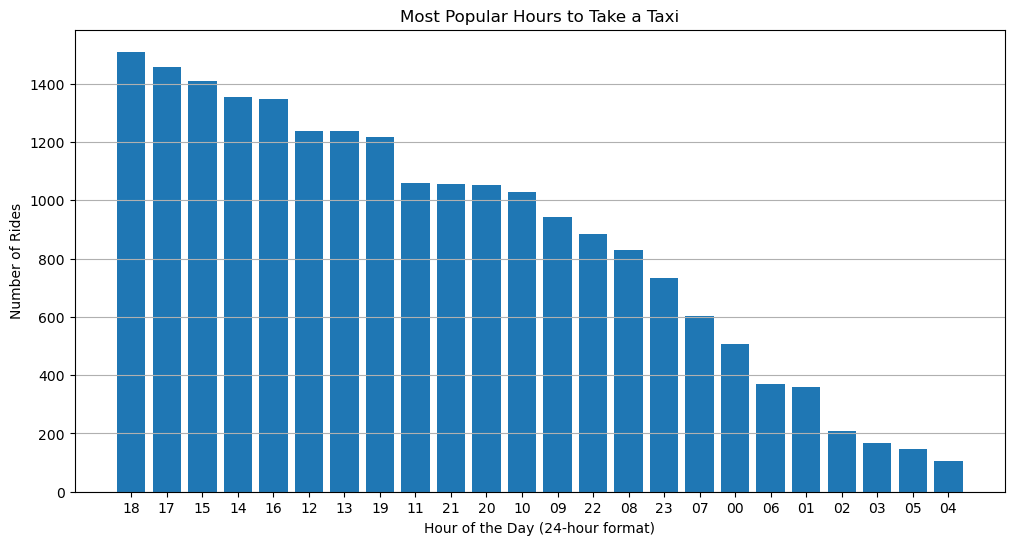

In [84]:
most_popular_hour(query_1_result)

### Visualization 2

In [85]:
QUERY_V2 = """
SELECT strftime('%m', pickup_datetime) AS month,
       AVG(trip_distance) AS avg_distance,
       COUNT(*) AS sample_size,
       SUM(trip_distance * trip_distance) AS sum_squared,
       SUM(trip_distance) AS sum_distance
FROM (
    SELECT pickup_datetime, trip_distance
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    UNION ALL
    SELECT pickup_datetime, trip_distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
) combined_trips
GROUP BY month
"""

In [86]:
# Create a pandas data frame of data 
data_v2 = get_data_for_visual(QUERY_V2, engine)

2024-12-07 14:20:32,915 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:20:32,924 INFO sqlalchemy.engine.Engine 
SELECT strftime('%m', pickup_datetime) AS month,
       AVG(trip_distance) AS avg_distance,
       COUNT(*) AS sample_size,
       SUM(trip_distance * trip_distance) AS sum_squared,
       SUM(trip_distance) AS sum_distance
FROM (
    SELECT pickup_datetime, trip_distance
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    UNION ALL
    SELECT pickup_datetime, trip_distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
) combined_trips
GROUP BY month

2024-12-07 14:20:32,955 INFO sqlalchemy.engine.Engine [raw sql] ()


2024-12-07 14:20:33,202 INFO sqlalchemy.engine.Engine ROLLBACK


In [90]:
def calculate_confidence_intervals(data_v2):
    """
    Calculate the standard deviation, margin of error, and 90% confidence intervals 
    for the monthly trip distance data.

    Parameters:
        data_v2 (pd.DataFrame): DataFrame containing aggregated monthly trip data.

    Returns:
        pd.DataFrame: DataFrame with added columns for standard deviation, margin of error,
                      and confidence intervals (lower and upper bounds).
    """
    # Calculate standard deviation
    data_v2["stddev"] = np.sqrt(
        (data_v2["sum_squared"] / data_v2["sample_size"]) - 
        (data_v2["sum_distance"] / data_v2["sample_size"])**2
    )

    # Calculate the margin of error for 90% confidence interval (Z = 1.645)
    z = 1.645
    data_v2["margin_error"] = z * (data_v2["stddev"] / np.sqrt(data_v2["sample_size"]))

    # Calculate confidence intervals
    data_v2["lower_bound"] = data_v2["avg_distance"] - data_v2["margin_error"]
    data_v2["upper_bound"] = data_v2["avg_distance"] + data_v2["margin_error"]

    return data_v2

calculate_confidence_intervals(data_v2)

,month,avg_distance,sample_size,sum_squared,sum_distance,stddev,margin_error,lower_bound,upper_bound
0,01,3.707572,3728,117734.3597,13821.83,4.223152,0.113780,3.593793,3.821352
1,02,3.714004,3701,113077.6523,13745.53,4.093830,0.110697,3.603307,3.824701
2,03,3.755962,3715,120042.1760,13953.40,4.266800,0.115157,3.640806,3.871119
3,04,3.639898,3724,110002.7632,13554.98,4.036089,0.108798,3.531100,3.748696
4,05,3.995989,3722,131261.0075,14873.07,4.392987,0.118451,3.877538,4.114439
5,06,4.022006,3708,135018.3230,14913.60,4.498463,0.121523,3.900483,4.143530
6,07,4.000539,3691,130938.6349,14765.99,4.412573,0.119477,3.881062,4.120017
7,08,4.006804,3683,132636.9262,14757.06,4.467528,0.121097,3.885708,4.127901
8,09,3.889286,2955,94166.0698,11492.84,4.091472,0.123813,3.765473,4.013099
9,10,3.870014,2953,95857.6405,11428.15,4.181399,0.126577,3.743436,3.996591


In [91]:
def plot_average_trip_distance(data_v2):
    """
    Plot the average trip distance per month with a 90% confidence interval 
    shaded around the average distance.

    Parameters:
        data_v2 (pd.DataFrame): DataFrame containing the monthly data with confidence intervals.
    """
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(data_v2["month"], data_v2["avg_distance"], label="Average Distance", color="blue", marker='o')
    plt.fill_between(data_v2["month"], data_v2["lower_bound"], data_v2["upper_bound"], 
                     color="blue", alpha=0.2, label="90% CI")

    # Add labels and legend
    plt.title("Average Trip Distance with 90% Confidence Interval")
    plt.xlabel("Month")
    plt.ylabel("Average Distance (miles)")
    plt.legend()
    plt.grid(True)
    plt.show()


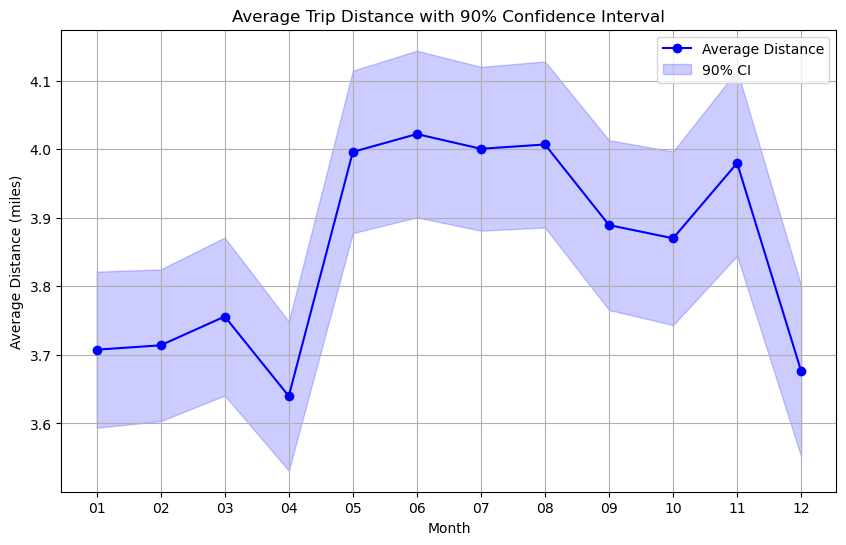

In [92]:
plot_average_trip_distance(data_v2)

### Visualization 3

In [101]:
QUERY_V3 = """
SELECT 
    strftime('%w', combined_trips.pickup_datetime) AS day,
    SUM(CASE WHEN combined_trips.zone = "JFK Airport" THEN 1 ELSE 0 END) AS jfk_rides,
    SUM(CASE WHEN combined_trips.zone = "Newark Airport" THEN 1 ELSE 0 END) AS newark_rides,
    SUM(CASE WHEN combined_trips.zone = "LaGuardia Airport" THEN 1 ELSE 0 END) AS laguardia_rides
FROM (
    SELECT t.pickup_datetime, t.dropoff_location_id, z.location_id, z.zone
    FROM taxi_trips t
    JOIN taxi_zones z ON t.dropoff_location_id = z.location_id
    WHERE z.zone IN ("JFK Airport", "Newark Airport", "LaGuardia Airport")
    UNION ALL
    SELECT u.pickup_datetime, u.dropoff_location_id, z.location_id, z.zone
    FROM uber_trips u
    JOIN taxi_zones z ON u.dropoff_location_id = z.location_id
    WHERE z.zone IN ("JFK Airport", "Newark Airport", "LaGuardia Airport")
) AS combined_trips
GROUP BY day
ORDER BY day;
"""

In [102]:
def plot_most_popular_aiport_rides(query, engine):
    """
    Visualize the number of rides to JFK, Newark, and LaGuardia airports for each day of the week.

    Parameters:
        query (str): SQL query to run. 
        engine: SQLAlchemy engine object to execute the query.

    Returns:
        None: Displays the visualization.
    """

    # Execute the query
    data_v3 = get_data_for_visual(query, engine)

    # Map days from numbers to names
    day_mapping = {
        "0": "Sunday", "1": "Monday", "2": "Tuesday", "3": "Wednesday",
        "4": "Thursday", "5": "Friday", "6": "Saturday"
    }
    data_v3["day"] = data_v3["day"].map(day_mapping)
    
    # Plot a grouped bar chart
    ax = data_v3[['newark_rides','jfk_rides', 'laguardia_rides']].plot(kind='bar', figsize=(10, 6))

    # Labeling
    ax.set_title("Rides to Airports by Day of the Week", fontsize=14)
    ax.set_xlabel("Day of the Week", fontsize=12)
    ax.set_ylabel("Number of Rides", fontsize=12)

    # Customize x-axis ticks
    ax.set_xticklabels(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], rotation=0)

    # Show the plot
    plt.tight_layout()
    plt.show()



2024-12-07 14:30:58,475 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:30:58,480 INFO sqlalchemy.engine.Engine 
SELECT 
    strftime('%w', combined_trips.pickup_datetime) AS day,
    SUM(CASE WHEN combined_trips.zone = "JFK Airport" THEN 1 ELSE 0 END) AS jfk_rides,
    SUM(CASE WHEN combined_trips.zone = "Newark Airport" THEN 1 ELSE 0 END) AS newark_rides,
    SUM(CASE WHEN combined_trips.zone = "LaGuardia Airport" THEN 1 ELSE 0 END) AS laguardia_rides
FROM (
    SELECT t.pickup_datetime, t.dropoff_location_id, z.location_id, z.zone
    FROM taxi_trips t
    JOIN taxi_zones z ON t.dropoff_location_id = z.location_id
    WHERE z.zone IN ("JFK Airport", "Newark Airport", "LaGuardia Airport")
    UNION ALL
    SELECT u.pickup_datetime, u.dropoff_location_id, z.location_id, z.zone
    FROM uber_trips u
    JOIN taxi_zones z ON u.dropoff_location_id = z.location_id
    WHERE z.zone IN ("JFK Airport", "Newark Airport", "LaGuardia Airport")
) AS combined_trips
GROUP BY day
ORDER

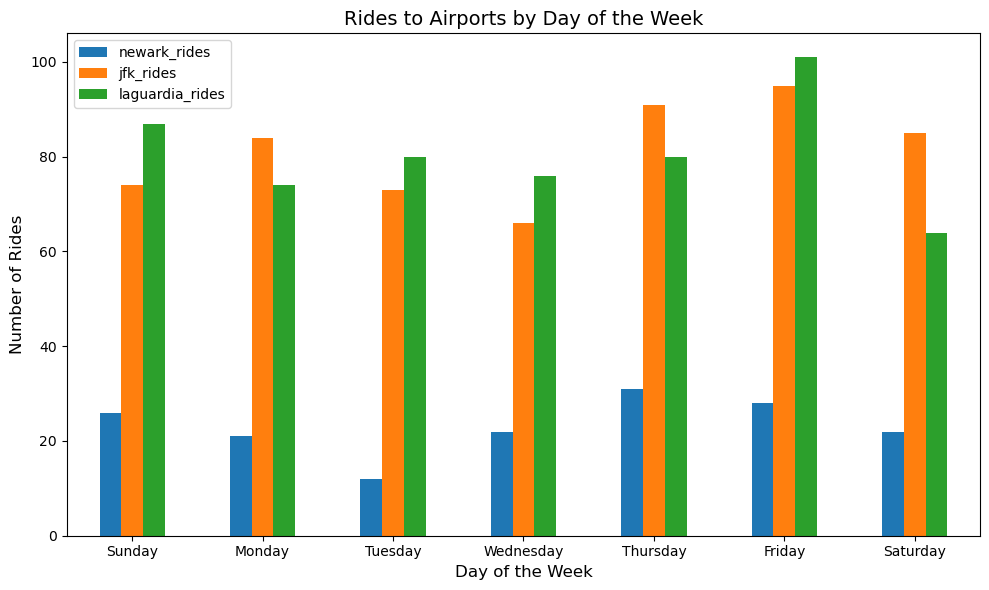

In [103]:
plot_most_popular_aiport_rides(QUERY_V3, engine)

### Visualization 4

In [104]:
QUERY_V4 = """
SELECT
    strftime('%Y-%m', pickup_datetime) AS month,
    SUM(base_passenger_fare) AS base_fare,
    SUM(mta_tax) AS total_tax,
    SUM(tolls_amount) AS total_toll,
    SUM(rush_hour_surcharge) + SUM(improvement_surcharge) + SUM(congestion_surcharge) AS total_surcharge,
    SUM(airport_fee) AS total_airport_fee,
    'Taxi' AS ride_type
FROM taxi_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY month
UNION ALL
SELECT
    strftime('%Y-%m', pickup_datetime) AS month,
    SUM(base_passenger_fare) AS base_fare,
    SUM(black_car_fund_fee) + SUM(congestion_surcharge) AS total_surcharge,
    SUM(sales_tax) AS total_tax,
    SUM(tolls_amount) AS total_toll,
    SUM(airport_fee) AS total_airport_fee,
    'Uber' AS ride_type
FROM uber_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY month
"""

In [106]:
def plot_trip_fares(query, engine):
    """
    Visualize the fares for Ubers and taxis as well as the breakdown of the fares.

    Parameters:
        query (str): SQL Query to run. 
        engine: SQLAlchemy engine object to execute the query.

    Returns:
        None: Displays the visualization.
    """

    data_v4 = get_data_for_visual(QUERY_V4, engine)

        # Calculate total fare (base fare + all other components)
    data_v4["total_fare"] = data_v4["base_fare"] + data_v4["total_tax"] + data_v4["total_toll"] + \
                            data_v4["total_surcharge"] + data_v4["total_airport_fee"].fillna(0)

    # Convert month to datetime for better sorting
    data_v4["month"] = pd.to_datetime(data_v4["month"])

    # Group by month and ride type to sum the different components
    grouped_data = data_v4.groupby(["month", "ride_type"]).sum().reset_index()

    # Separate data for visualization
    taxi_data = grouped_data[grouped_data["ride_type"] == "Taxi"]
    uber_data = grouped_data[grouped_data["ride_type"] == "Uber"]

    # Plot the data
    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Yellow Taxi Monthly Fare Breakdown
    ax[0].plot(taxi_data["month"], taxi_data["base_fare"], label="Base Fare", marker='o')
    ax[0].plot(taxi_data["month"], taxi_data["total_tax"], label="Tax", marker='o')
    ax[0].plot(taxi_data["month"], taxi_data["total_toll"], label="Toll", marker='o')
    ax[0].plot(taxi_data["month"], taxi_data["total_surcharge"], label="Surcharge", marker='o')
    ax[0].plot(taxi_data["month"], taxi_data["total_airport_fee"], label="Airport Fee", marker='o')
    ax[0].set_title("Yellow Taxi: Monthly Earned Fares Breakdown (2020-2024)")
    ax[0].set_ylabel("Fare Amount ($)")
    ax[0].legend()
    ax[0].grid(True)

    # Uber Monthly Fare Breakdown
    ax[1].plot(uber_data["month"], uber_data["base_fare"], label="Base Fare", marker='o')
    ax[1].plot(uber_data["month"], uber_data["total_tax"], label="Tax", marker='o')
    ax[1].plot(uber_data["month"], uber_data["total_toll"], label="Toll", marker='o')
    ax[1].plot(uber_data["month"], uber_data["total_surcharge"], label="Surcharge", marker='o')
    ax[1].plot(uber_data["month"], uber_data["total_airport_fee"], label="Airport Fee", marker='o')
    ax[1].set_title("Uber: Monthly Earned Fares Breakdown (2020-2024)")
    ax[1].set_ylabel("Fare Amount ($)")
    ax[1].set_xlabel("Month")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


2024-12-07 14:34:29,560 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:34:29,563 INFO sqlalchemy.engine.Engine 
SELECT
    strftime('%Y-%m', pickup_datetime) AS month,
    SUM(base_passenger_fare) AS base_fare,
    SUM(mta_tax) AS total_tax,
    SUM(tolls_amount) AS total_toll,
    SUM(rush_hour_surcharge) + SUM(improvement_surcharge) + SUM(congestion_surcharge) AS total_surcharge,
    SUM(airport_fee) AS total_airport_fee,
    'Taxi' AS ride_type
FROM taxi_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY month
UNION ALL
SELECT
    strftime('%Y-%m', pickup_datetime) AS month,
    SUM(base_passenger_fare) AS base_fare,
    SUM(black_car_fund_fee) + SUM(congestion_surcharge) AS total_surcharge,
    SUM(sales_tax) AS total_tax,
    SUM(tolls_amount) AS total_toll,
    SUM(airport_fee) AS total_airport_fee,
    'Uber' AS ride_type
FROM uber_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY month

2024-12-07 14:34:29,564 INFO 

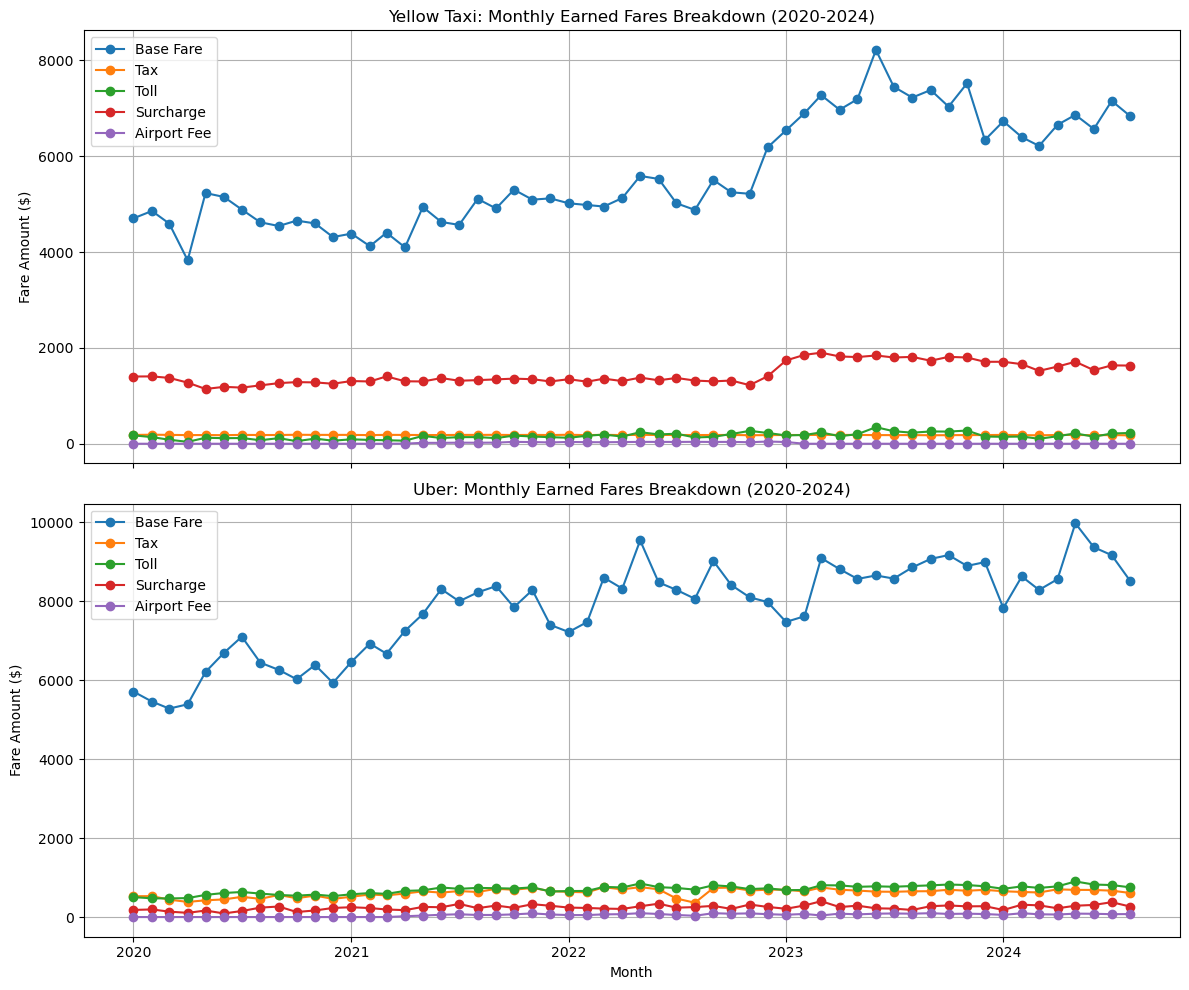

In [107]:
plot_trip_fares(QUERY_V4, engine)

### Visualization 5

In [110]:
QUERY_V5 = """
SELECT 
    trip_distance, 
    tip_amount, 
    d.daily_precipitation,
    "taxi" AS trip_type
FROM taxi_trips t 
JOIN daily_weather d
    ON strftime('%Y-%m-%d', t.pickup_datetime) = strftime('%Y-%m-%d', d.date)
WHERE pickup_datetime BETWEEN '2022-01-01' AND '2022-12-31'
UNION ALL 
SELECT 
    trip_distance, 
    tip_amount,
    d.daily_precipitation,
    "uber" AS trip_type
FROM uber_trips u
JOIN daily_weather d
    ON strftime('%Y-%m-%d', u.pickup_datetime) = strftime('%Y-%m-%d', d.date)
WHERE pickup_datetime BETWEEN '2022-01-01' AND '2022-12-31'
""" 

In [111]:
def plot_tip_vs_factors(query, engine):
    """
    Visualize the impact of rain or distance on tip.

    Parameters:
        query (str): SQL Query to run. 
        engine: SQLAlchemy engine object to execute the query.

    Returns:
        None: Displays the visualization.
    """
    data_v5 = get_data_for_visual(QUERY_V5, engine)

    # Create a figure with 2 rows and 2 columns for subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Filter data for taxi and uber
    taxi_data = data_v5[data_v5['trip_type'] == 'taxi']
    uber_data = data_v5[data_v5['trip_type'] == 'uber']

    # Scatter plot 1: Distance vs Tip Amount for Taxi
    sns.scatterplot(data=taxi_data, x='trip_distance', y='tip_amount', ax=axs[0, 0], color='blue')
    axs[0, 0].set_title('Distance vs Tip Amount for Taxi')
    axs[0, 0].set_xlabel('Trip Distance')
    axs[0, 0].set_ylabel('Tip Amount')

    # Scatter plot 2: Distance vs Tip Amount for Uber
    sns.scatterplot(data=uber_data, x='trip_distance', y='tip_amount', ax=axs[0, 1], color='green')
    axs[0, 1].set_title('Distance vs Tip Amount for Uber')
    axs[0, 1].set_xlabel('Trip Distance')
    axs[0, 1].set_ylabel('Tip Amount')

    # Scatter plot 3: Precipitation vs Tip Amount for Taxi
    sns.scatterplot(data=taxi_data, x='daily_precipitation', y='tip_amount', ax=axs[1, 0], color='red')
    axs[1, 0].set_title('Precipitation vs Tip Amount for Taxi')
    axs[1, 0].set_xlabel('Daily Precipitation')
    axs[1, 0].set_ylabel('Tip Amount')

    # Scatter plot 4: Precipitation vs Tip Amount for Uber
    sns.scatterplot(data=uber_data, x='daily_precipitation', y='tip_amount', ax=axs[1, 1], color='purple')
    axs[1, 1].set_title('Precipitation vs Tip Amount for Uber')
    axs[1, 1].set_xlabel('Daily Precipitation')
    axs[1, 1].set_ylabel('Tip Amount')

    # Adjust layout for better spacing between subplots
    plt.tight_layout()
    plt.show()


2024-12-07 14:36:54,986 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:36:54,989 INFO sqlalchemy.engine.Engine 
SELECT 
    trip_distance, 
    tip_amount, 
    d.daily_precipitation,
    "taxi" AS trip_type
FROM taxi_trips t 
JOIN daily_weather d
    ON strftime('%Y-%m-%d', t.pickup_datetime) = strftime('%Y-%m-%d', d.date)
WHERE pickup_datetime BETWEEN '2022-01-01' AND '2022-12-31'
UNION ALL 
SELECT 
    trip_distance, 
    tip_amount,
    d.daily_precipitation,
    "uber" AS trip_type
FROM uber_trips u
JOIN daily_weather d
    ON strftime('%Y-%m-%d', u.pickup_datetime) = strftime('%Y-%m-%d', d.date)
WHERE pickup_datetime BETWEEN '2022-01-01' AND '2022-12-31'

2024-12-07 14:36:54,994 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:37:21,929 INFO sqlalchemy.engine.Engine ROLLBACK


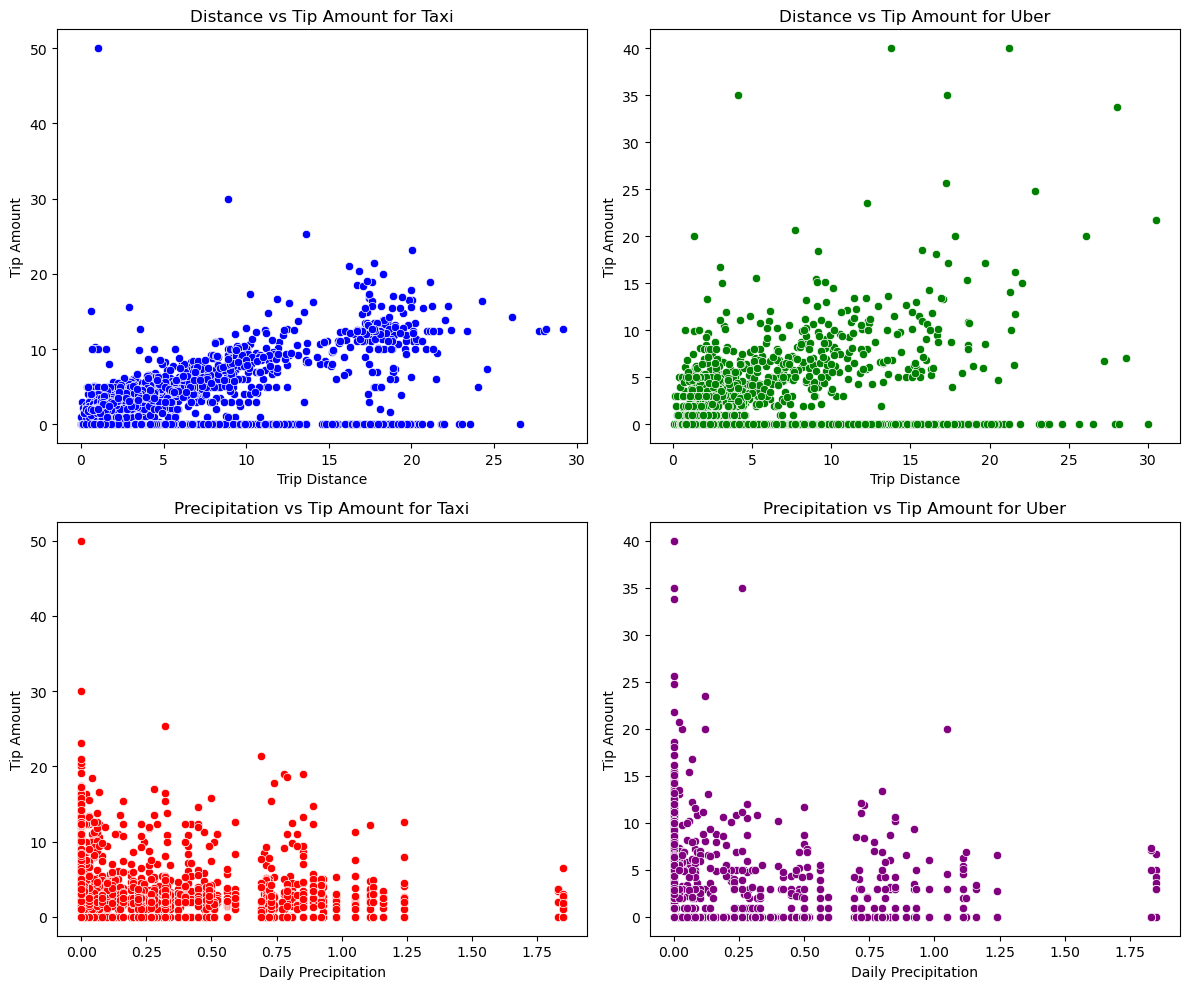

In [112]:
plot_tip_vs_factors(QUERY_V5, engine)

### Visualization 6

In [113]:
QUERY_V6 = """
SELECT
    centroid_lat as LAT, 
    centroid_lon as LON 
FROM taxi_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
UNION ALL
SELECT
    centroid_lat as LAT, 
    centroid_lon as LON
FROM uber_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
"""

In [121]:
def plot_ride_heatmap(query, engine):
    """
    Visualize the frequency of rides via a heatmap.

    Parameters:
        query (str): SQL Query to run. 
        engine: SQLAlchemy engine object to execute the query.

    Returns:
        None: Displays the visualization.
    """
    data_v6 = get_data_for_visual(QUERY_V6, engine)

    # Create base map centered at the average location
    map_center = [data_v6["LAT"].mean(), data_v6["LON"].mean()]
    m = folium.Map(location=map_center, zoom_start=12)

    # Add Heatmap
    HeatMap(data_v6[["LAT", "LON"]].values, radius=10).add_to(m)

    # Show us the heatmap
    display(m)

In [122]:
plot_ride_heatmap(QUERY_V6, engine)

2024-12-07 14:42:07,301 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-07 14:42:07,306 INFO sqlalchemy.engine.Engine 
SELECT
    centroid_lat as LAT, 
    centroid_lon as LON 
FROM taxi_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
UNION ALL
SELECT
    centroid_lat as LAT, 
    centroid_lon as LON
FROM uber_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'

2024-12-07 14:42:07,308 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-12-07 14:42:07,372 INFO sqlalchemy.engine.Engine ROLLBACK
